# Reading Data and computing $U,V$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [3]:
# uses joeys code copypastad from his notebook, should ideally put this in a data utils or something
with open('data/movies.txt', 'r') as f:
    movies = f.read().split('\r')
with open ('data/data.txt', 'r') as f:
    ratings = f.read().split('\r')

movies_list = []
for m in movies:
    movies_list.append(m.split('\t'))

ratings_list = []
for r in ratings:
    ratings_list.append(r.split('\t'))

movies_df = pd.DataFrame(movies_list, columns = ['Movie Id', 'Movie Title', 'Unknown', 'Action', 'Adventure', 'Animation',\
                                                 'Childrens', 'Comedy', 'Crime', 'Documentary', \
                                                 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', \
                                                 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

ratings_df =  pd.DataFrame(ratings_list, columns = ['User Id', 'Movie Id', 'Rating'])

movies_df =  movies_df.apply(pd.to_numeric, errors='ignore')
ratings_df = ratings_df.apply(pd.to_numeric)
r_df = ratings_df.pivot(index = 'Movie Id', columns ='User Id', values = 'Rating').fillna(0)

In [25]:
# currently uses rohan's code for factorization, may not be ideal but can replace later
from factorize import factor_matrix,error # now uses joey's updated code with biases

In [43]:
# write the list of movie titles as they appear to a file, so we can search for them later
movie_titles = movies_df["Movie Title"].values
f = open('movie_titles.txt', 'w')
f.writelines(["%s\n" % item  for item in movie_titles])

In [26]:
k = 20 # use 20 latent factors
reg_val = .1 # empirically from plots this was good
ratings = np.loadtxt('data/ratings.out',delimiter=',')
mean_rating = np.mean(ratings[np.nonzero(ratings)])
# Take out mean of all ratings
ratings_normed = ratings.copy()
ratings_normed[np.nonzero(ratings_normed)] -= mean_rating

U, V, a, b = factor_matrix(ratings_normed, 20, reg = reg_val)

0 0.936922777934
1 0.863942574976
2 0.832992004597
3 0.814917398091
4 0.803203071884
5 0.794837094751
6 0.785301335269
7 0.776833610254
8 0.769519947197
9 0.760329927026
10 0.752164553288
11 0.743315724445
12 0.736049691652
13 0.727544550248
14 0.719655239022
15 0.712333528528
16 0.705209562416
17 0.697960776225
18 0.691780653153
19 0.68488044638
20 0.67844716836
21 0.67207962046
22 0.666295790079
23 0.660158399266
24 0.654971105406
25 0.649133942822
26 0.643889760729
27 0.638496905253
28 0.633520773627
29 0.628823126128
30 0.624472282998
31 0.619716697623
32 0.615946634579
33 0.611750797073
34 0.608200912914
35 0.604715217564
36 0.60063564997
37 0.597330417903
38 0.594345370035
39 0.59132607244
40 0.588472577016
41 0.585554604703
42 0.583150519706
43 0.580178596305
44 0.577868034984
45 0.575610968418
46 0.573787959547
47 0.571011598171
48 0.568848355686
49 0.567215468074
50 0.565150729886


In [27]:
# get SVD of V and project it
a,b,c = np.linalg.svd(V)
print np.shape(a)
print np.shape(b)
print np.shape(c)
print np.shape(V) # U has the movies
V_proj = np.dot(V,c[:2].T)
print np.shape(V_proj)

(1682, 1682)
(20,)
(20, 20)
(1682, 20)
(1682, 2)


Now we have latent vectors U and V, projected into 2-d space. We want to visualize them. U contains features for each movie, while V contains features for each user. 

# Ten Random Movies

In [61]:
inds = np.random.choice(range(1682),10)
vals = V_proj[inds]
xs = vals[:,0]
ys = vals[:,1]
titles = np.array(movies_df["Movie Title"].tolist())[inds] # gets 10 random movies

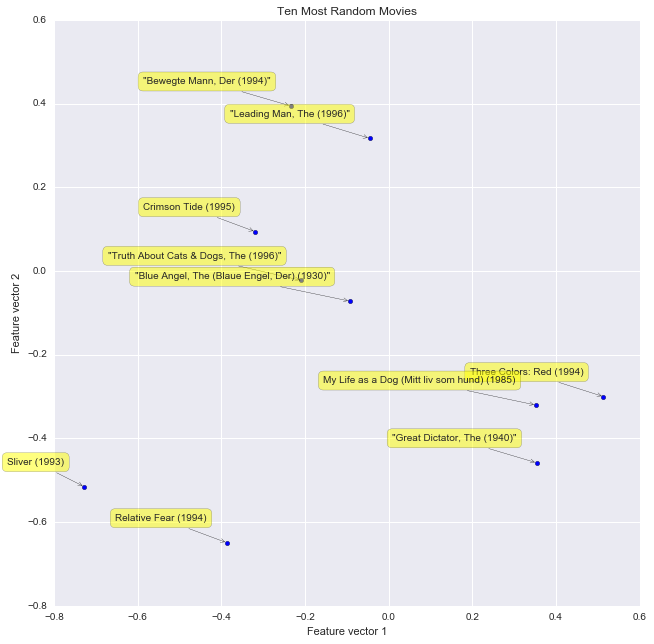

In [62]:
plt.scatter(xs, ys, marker='o')

for label, x, y in zip(titles, xs, ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Ten Most Random Movies")
plt.xlabel("Feature vector 1")
plt.ylabel("Feature vector 2")
plt.savefig("ten_random.png")

# Ten Most Popular Movies

In [63]:
r_df['Total Ratings'] = (r_df != 0).sum(axis=1)
ten_most_popular = r_df.sort_values('Total Ratings', ascending=False)[:10].index
ten_most_popular_inds = np.array(ten_most_popular)-1
vals = V_proj[ten_most_popular_inds]
xs = vals[:,0]
ys = vals[:,1]
titles = np.array(movies_df["Movie Title"].tolist())[ten_most_popular_inds] 

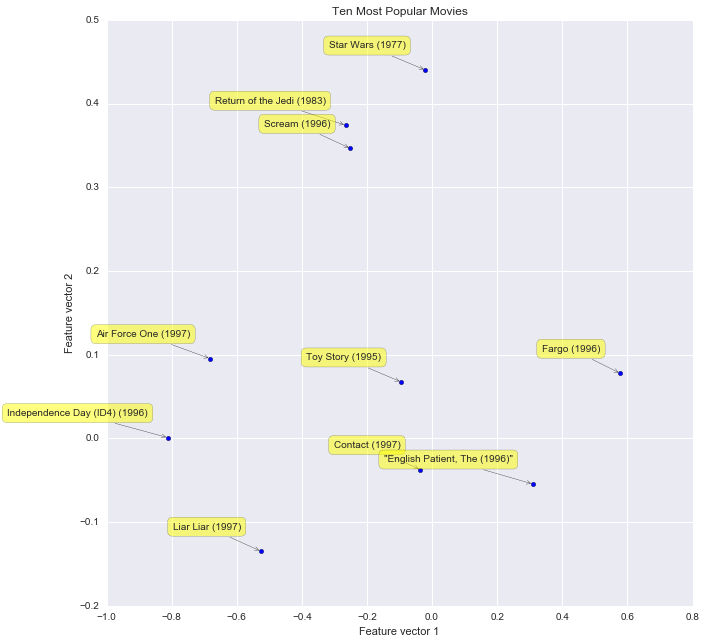

In [64]:
plt.scatter(xs, ys, marker='o')

for label, x, y in zip(titles, xs, ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),rotation = 0)
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Ten Most Popular Movies")
plt.xlabel("Feature vector 1")
plt.ylabel("Feature vector 2")
plt.savefig("ten_most_popular.png")

# Ten best movies 

In [65]:
r_filtered_df = r_df[r_df['Total Ratings'] >= 5].drop(['Total Ratings'], axis=1)
r_filtered_df['Average Rating'] = r_filtered_df.replace(0, np.nan).mean(axis=1)
r_filtered_df.sort_values(['Average Rating'], ascending=False)[:10]
ten_best = r_filtered_df.sort_values(['Average Rating'], ascending=False)[:10].index
ten_best_inds = np.array(ten_best) -1
vals = V_proj[ten_best_inds]
xs = vals[:,0]
ys = vals[:,1]
titles = np.array(movies_df["Movie Title"].tolist())[ten_best_inds] 

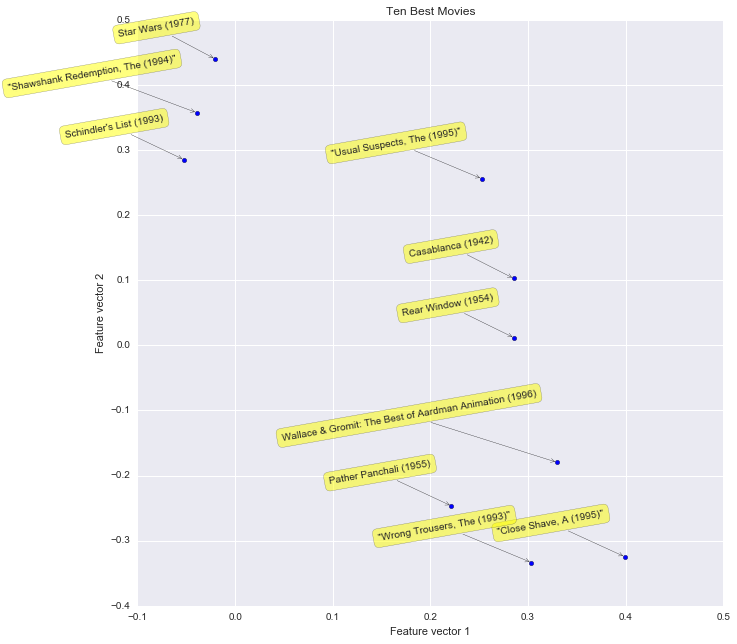

In [66]:
plt.scatter(xs, ys, marker='o')

for label, x, y in zip(titles, xs, ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),rotation=10)
    
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Ten Best Movies")
plt.xlabel("Feature vector 1")
plt.ylabel("Feature vector 2")
plt.savefig("ten_best.png")

# Ten Best from 3 genres

In [ ]:
genres = ['Drama', 'Comedy', 'Thriller'] #top 3 most popular genres

## Drama 

In [69]:
drama_movies = movies_df[movies_df['Drama'] == 1]['Movie Id'].values
drama_movies_inds = np.random.choice(np.array(drama_movies)-1,10)
# pick ten random ones, can do ten best or ten most pop later
vals = V_proj[drama_movies_inds]
xs = vals[:,0]
ys = vals[:,1]
titles = np.array(movies_df["Movie Title"].tolist())[drama_movies_inds]

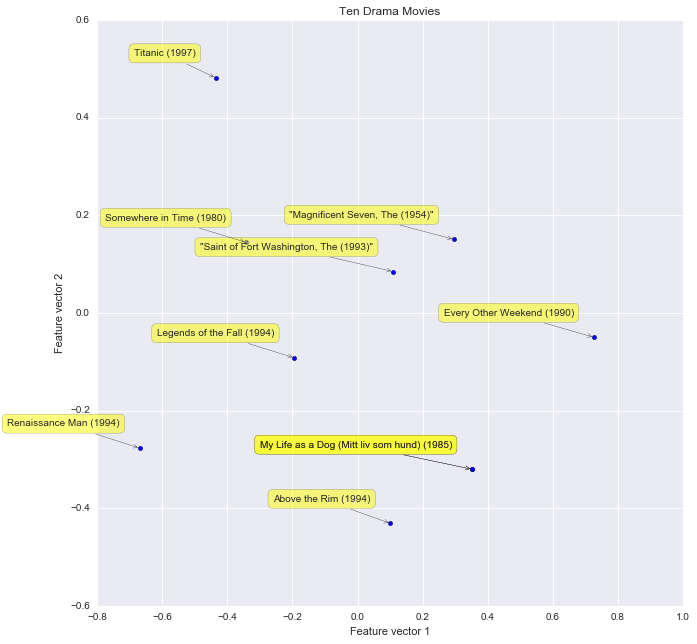

In [70]:
plt.scatter(xs, ys, marker='o')

for label, x, y in zip(titles, xs, ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),rotation = 0)
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Ten Drama Movies")
plt.xlabel("Feature vector 1")
plt.ylabel("Feature vector 2")
plt.savefig("ten_random_drama.png")

## Comedy 

In [73]:
comedy_movies = movies_df[movies_df['Comedy'] == 1]['Movie Id'].values
comedy_movies_inds = np.random.choice(np.array(comedy_movies)-1,10)
# pick ten random ones, can do ten best or ten most pop later
vals = V_proj[comedy_movies_inds]
xs = vals[:,0]
ys = vals[:,1]
titles = np.array(movies_df["Movie Title"].tolist())[comedy_movies_inds]

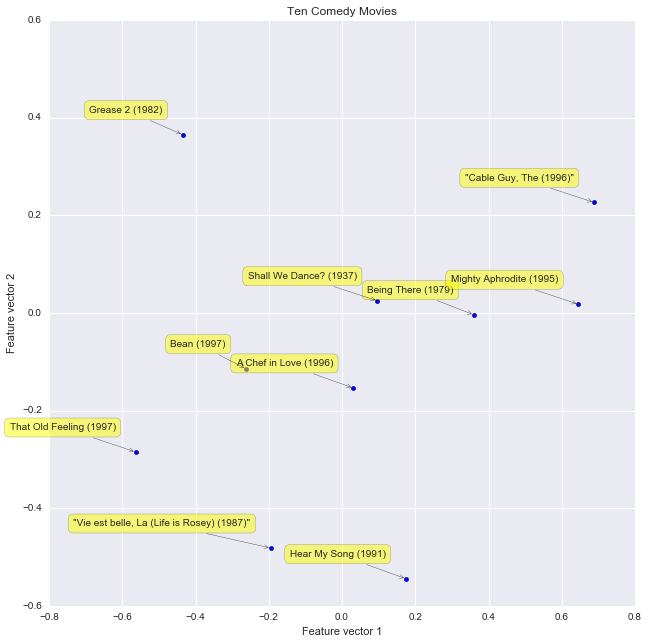

In [74]:
plt.scatter(xs, ys, marker='o')

for label, x, y in zip(titles, xs, ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),rotation =0)

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Ten Comedy Movies")
plt.xlabel("Feature vector 1")
plt.ylabel("Feature vector 2")
plt.savefig("ten_random_comedy.png")

## Thriller

In [75]:
thriller_movies = movies_df[movies_df['Thriller'] == 1]['Movie Id'].values
thriller_movies_inds = np.random.choice(np.array(thriller_movies)-1,10)
# pick ten random ones, can do ten best or ten most pop later
vals = V_proj[thriller_movies_inds]
thrill_xs = vals[:,0]
thrill_ys = vals[:,1]
thrill_titles = np.array(movies_df["Movie Title"].tolist())[thriller_movies_inds]

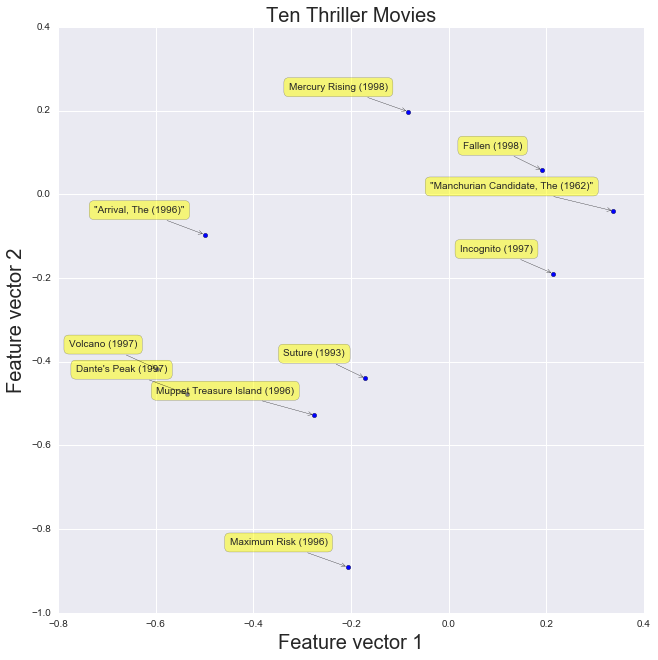

In [76]:
plt.scatter(thrill_xs, thrill_ys, marker='o')

for label, x, y in zip(thrill_titles, thrill_xs, thrill_ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Ten Thriller Movies",fontsize = 20)
plt.xlabel("Feature vector 1",fontsize = 20)
plt.ylabel("Feature vector 2",fontsize = 20)
plt.savefig("ten_random_thriller.png")

In [77]:
# create the plot that Yisong made (1)
titles = movies_df["Movie Title"].values
yisong_movies = [
    "My Fair Lady (1964)",
    "Free Willy 2: The Adventure Home (1995)", # lmao required 'the adventure home'
    "Free Willy (1993)",
    "Batman Forever (1995)",
    "Bad Boys (1995)",
    "\"Birdcage, The (1996)\"",
    "Star Wars (1977)",
    "Return of the Jedi (1983)",
    "\"Empire Strikes Back, The (1980)\"", # lol quotes
    "\"Nutty Professor, The (1996)\"",
    "GoldenEye (1995)",
    "Apollo 13 (1995)",
    "Twelve Monkeys (1995)",
    "2001: A Space Odyssey (1968)",
    "Fargo (1996)",
    "Seven (Se7en) (1995)",
    "Aliens (1986)",
    "Braveheart (1995)",
    "Forrest Gump (1994)"
]
inds = []
for movie in yisong_movies:
    inds.append(list(titles).index(movie))
vals = V_proj[inds]
yisong_xs = vals[:,0]
yisong_ys = vals[:,1]
yisong_titles = np.array(movies_df["Movie Title"].tolist())[inds]

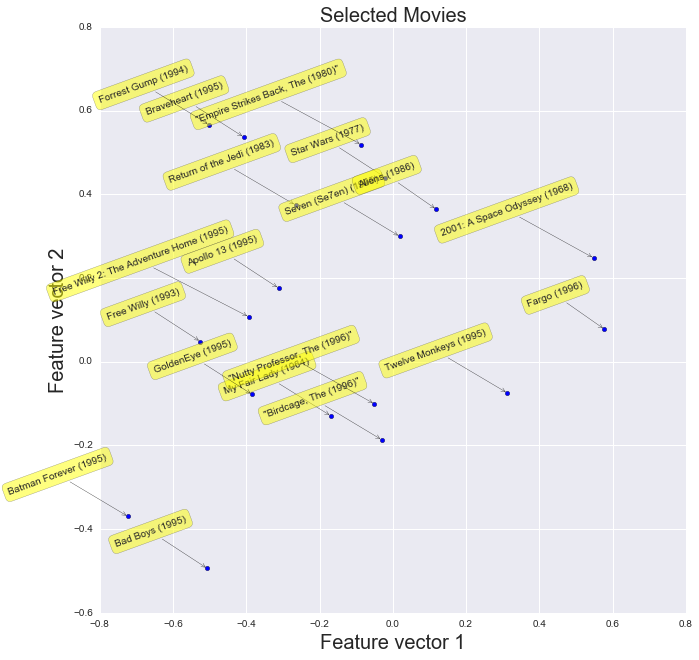

In [78]:
plt.scatter(yisong_xs, yisong_ys, marker='o')

for label, x, y in zip(yisong_titles, yisong_xs, yisong_ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),rotation = 20)

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Selected Movies",fontsize = 20)
plt.xlabel("Feature vector 1",fontsize = 20)
plt.ylabel("Feature vector 2",fontsize = 20)
plt.savefig("choice_movies.png")